In [31]:
# import necessary modules
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from codonUtils import utils
from codonoptimizer import MonteCarlo
from codonTable import codonTable
import bct
import pickle
import subprocess
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
help(MonteCarlo)

Help on class MonteCarlo in module codonoptimizer:

class MonteCarlo(builtins.object)
 |  MonteCarlo: A class designed to optimize a codon table given an
 |  arbitrary objective function to minimize/maximize
 |  
 |  Methods defined here:
 |  
 |  GDA(self, dW=None, W=0, W_stop=inf, maxIter=1000, preserveBlock=False, preserveStop=False, subFunc='minPRS')
 |      The Great Deluge Algorithm for optimizing an objective function over
 |      codon table space
 |      
 |      Parameters
 |      ----------
 |      - float dW=None: represents the rate of change (rain flux) of min
 |          allowable energy (water level); if None, initialized to 1% of
 |          cost(self.table)
 |      - float W=0: represents the initial minimal acceptable energy level
 |          (water level); defaults to 0
 |      - float W_stop=inf: represents the maximum allowable water level; stops
 |          algorithm when W > W_stop; defaults to an infinte value
 |      - int maxIter=1000: represents the maximum 

## Gathering Statistics

A set of adjacency matrices that preserve the degree, weight and strength distributions of the Standard Codon table graph were generated using bct.null_model_dir_sign() and used as a null model. A set of evolved tables were also generated and the densities of the resulting sets were compared.

In [4]:
%autoreload 2
# define number of trials to run
N = 1000
sim = MonteCarlo()
# preallocate memory for statistics
densities = np.zeros(N)
efficiencies = np.zeros(N)
clustCoeff = np.zeros(N)
modularities = np.zeros(N)
assortativities = np.zeros(N)
# perform N trials
for i in range(N):
    # generage graph
    ct, *dummy = sim.GDA(subFunc='SCV')
    ct = codonTable(ct)
    Cij = ct.adjMat
    # calculate statistics
    densities[i], *dummy = bct.density_und(Cij)
    efficiencies[i] = bct.efficiency_wei(Cij)
    clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, modularities[i] = bct.modularity_und(Cij)
    assortativities[i] = bct.assortativity_wei(Cij, 0)

In [5]:
# pickle resulting statistics so they don't have to be re calculated
stats = [densities, efficiencies, clustCoeff, modularities, assortativities]
with open('res/SCV.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

In [13]:
## Null Models
%autoreload 2
# define number of adjMats to generate
N = 10000
# get standard table
ct = codonTable()
C_st = ct.adjMat
# preallocate memory for statistics
null_densities = np.zeros(N)
null_efficiencies = np.zeros(N)
null_clustCoeff = np.zeros(N)
null_modularities = np.zeros(N)
null_assortativities = np.zeros(N)
# perform N trials
for i in range(N):
    # generate new null graph
    Cij, *dummy = bct.null_model_und_sign(C_st)
    # calculate statistics
    null_densities[i], *dummy = bct.density_und(Cij)
    null_efficiencies[i] = bct.efficiency_wei(Cij)
    null_clustCoeff[i], *dummy = bct.clustering_coef_wu(Cij)
    dummy, null_modularities[i] = bct.modularity_und(Cij)
    null_assortativities[i] = bct.assortativity_wei(Cij, 0)

/home/jon/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1024: RuntimeWarning: divide by zero encountered in double_scalars
  f = 1 - Wv[r] / S[j[o]]
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1025: RuntimeWarning: invalid value encountered in multiply
  P[j[o], :] *= f
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1026: RuntimeWarning: invalid value encountered in multiply
  P[:, j[o]] *= f
/home/jon/Dropbox/Lab/Arbitrary Translational Decoding/codon-tables/bctpy/bctpy-master/bct/algorithms/reference.py:1021: RuntimeWarning: divide by zero encountered in double_scalars
  f = 1 - Wv[r] / S[i[o]]
/home/jon/Dropbox/Lab/Arbitrary Translat

In [15]:
# pickle resulting statistics so they don't have to be re calculated
stats = [null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities]
with open('res/null.pickle', 'wb') as handle:
    pickle.dump(stats, handle)

In [5]:
## Visualize the data!!

# unpickle data
with open('res/minPRS.pickle', 'rb') as handle:
    PRS_densities, PRS_efficiencies, PRS_clustCoeff, PRS_modularities, PRS_assortativities  = pickle.load(handle)

with open('res/Gilis.pickle', 'rb') as handle:
    Gilis_densities, Gilis_efficiencies, Gilis_clustCoeff, Gilis_modularities, Gilis_assortativities  = pickle.load(handle)

with open('res/SCV.pickle', 'rb') as handle:
    SCV_densities, SCV_efficiencies, SCV_clustCoeff, SCV_modularities, SCV_assortativities  = pickle.load(handle)

with open('res/null.pickle', 'rb') as handle:
    null_densities, null_efficiencies, null_clustCoeff, null_modularities, null_assortativities  = pickle.load(handle)

## Densities

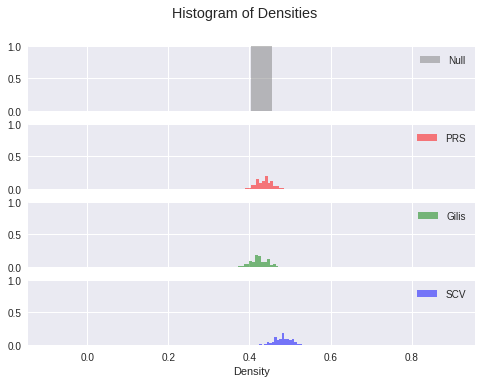

In [40]:
# plot histograms
fig, axarr = plt.subplots(4, sharex=True)
null_weights = np.ones_like(null_densities)/float(len(null_densities))
evo_weights = np.ones_like(PRS_densities)/float(len(PRS_densities))
axarr[0].hist(null_densities, 20, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(PRS_densities, 20, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[2].hist(Gilis_densities, 20, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[3].hist(SCV_densities, 20, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Densities')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 1)
plt.xlabel('Density')
#plt.savefig('../figs/density_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_dens_PRS, p_dens_PRS = stats.ks_2samp(PRS_densities, null_densities)
D_dens_Gilis, p_dens_Gilis = stats.ks_2samp(Gilis_densities, null_densities)
D_dens_SCV, p_dens_SCV = stats.ks_2samp(SCV_densities, null_densities)
# test if means are different
Z_dens_PRS, U_dens_PRS = stats.ranksums(PRS_densities, null_densities)
Z_dens_Gilis, U_dens_Gilis = stats.ranksums(Gilis_densities, null_densities)
Z_dens_SCV, U_dens_SCV = stats.ranksums(SCV_densities, null_densities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'PRS' : [D_dens_PRS, p_dens_PRS, Z_dens_PRS, U_dens_PRS],
    'Gilis' : [D_dens_Gilis, p_dens_Gilis, Z_dens_Gilis, U_dens_Gilis],
    'SCV' : [D_dens_SCV, p_dens_SCV, Z_dens_SCV, U_dens_SCV]
}
dens_stats = pd.DataFrame(dict, index=index)
dens_stats.to_html('res/dens_stats.html')

## Efficiencies

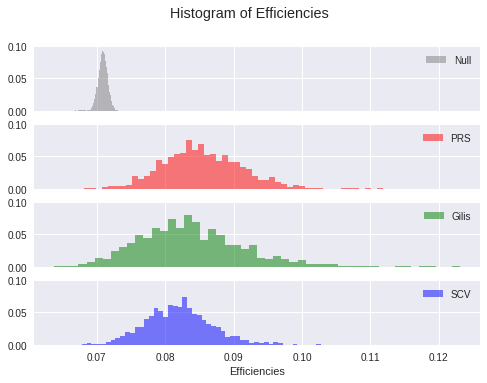

FileNotFoundError: [Errno 2] No such file or directory: '~/bin/wkhtmltoimage'

In [39]:
# plot histograms
fig, axarr = plt.subplots(4, sharex=True)
null_weights = np.ones_like(null_efficiencies)/float(len(null_efficiencies))
evo_weights = np.ones_like(PRS_efficiencies)/float(len(PRS_efficiencies))
axarr[0].hist(null_efficiencies, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(PRS_efficiencies, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[2].hist(Gilis_efficiencies, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[3].hist(SCV_efficiencies, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Efficiencies')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Efficiencies')
#plt.savefig('../figs/efficiency_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_eff_PRS, p_eff_PRS = stats.ks_2samp(PRS_efficiencies, null_efficiencies)
D_eff_Gilis, p_eff_Gilis = stats.ks_2samp(Gilis_efficiencies, null_efficiencies)
D_eff_SCV, p_eff_SCV = stats.ks_2samp(SCV_efficiencies, null_efficiencies)
# test if means are different
Z_eff_PRS, U_eff_PRS = stats.ranksums(PRS_efficiencies, null_efficiencies)
Z_eff_Gilis, U_eff_Gilis = stats.ranksums(Gilis_efficiencies, null_efficiencies)
Z_eff_SCV, U_eff_SCV = stats.ranksums(SCV_efficiencies, null_efficiencies)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'PRS' : [D_eff_PRS, p_eff_PRS, Z_eff_PRS, U_eff_PRS],
    'Gilis' : [D_eff_Gilis, p_eff_Gilis, Z_eff_Gilis, U_eff_Gilis],
    'SCV' : [D_eff_SCV, p_eff_SCV, Z_eff_SCV, U_eff_SCV]
}
eff_stats = pd.DataFrame(dict, index=index)
eff_stats.to_html('res/eff_stats.html')

## Clustering Coefficients

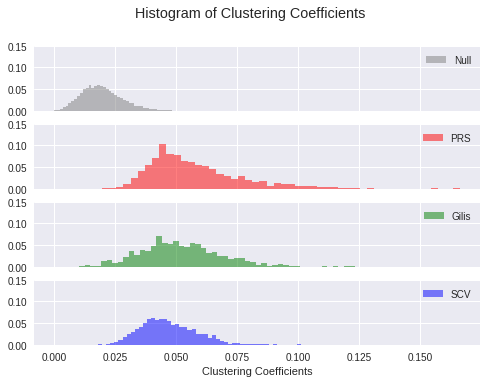

In [41]:
# plot histograms
fig, axarr = plt.subplots(4, sharex=True)
null_weights = np.ones_like(null_clustCoeff)/float(len(null_clustCoeff))
evo_weights = np.ones_like(PRS_clustCoeff)/float(len(PRS_clustCoeff))
axarr[0].hist(null_clustCoeff, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(PRS_clustCoeff, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[2].hist(Gilis_clustCoeff, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[3].hist(SCV_clustCoeff, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Clustering Coefficients')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.15)
plt.xlabel('Clustering Coefficients')
plt.savefig('../figs/clustering_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_clustCoeff_PRS, p_clustCoeff_PRS = stats.ks_2samp(PRS_clustCoeff, null_clustCoeff)
D_clustCoeff_Gilis, p_clustCoeff_Gilis = stats.ks_2samp(Gilis_clustCoeff, null_clustCoeff)
D_clustCoeff_SCV, p_clustCoeff_SCV = stats.ks_2samp(SCV_clustCoeff, null_clustCoeff)
# test if means are different
Z_clustCoeff_PRS, U_clustCoeff_PRS = stats.ranksums(PRS_clustCoeff, null_clustCoeff)
Z_clustCoeff_Gilis, U_clustCoeff_Gilis = stats.ranksums(Gilis_clustCoeff, null_clustCoeff)
Z_clustCoeff_SCV, U_clustCoeff_SCV = stats.ranksums(SCV_clustCoeff, null_clustCoeff)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'PRS' : [D_clustCoeff_PRS, p_clustCoeff_PRS, Z_clustCoeff_PRS, U_clustCoeff_PRS],
    'Gilis' : [D_clustCoeff_Gilis, p_clustCoeff_Gilis, Z_clustCoeff_Gilis, U_clustCoeff_Gilis],
    'SCV' : [D_clustCoeff_SCV, p_clustCoeff_SCV, Z_clustCoeff_SCV, U_clustCoeff_SCV]
}
clustCoeff_stats = pd.DataFrame(dict, index=index)
clustCoeff_stats.to_html('res/clust_stats.html')

## Modularities

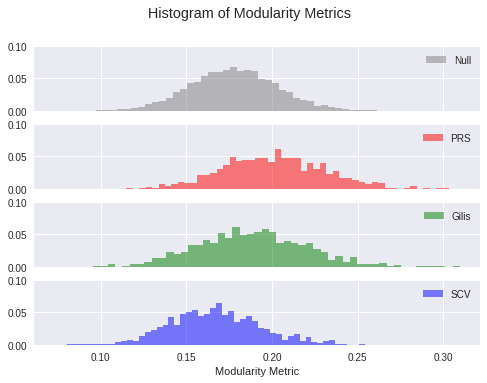

In [42]:
# plot histograms
fig, axarr = plt.subplots(4, sharex=True)
null_weights = np.ones_like(null_modularities)/float(len(null_modularities))
evo_weights = np.ones_like(PRS_modularities)/float(len(PRS_modularities))
axarr[0].hist(null_modularities, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(PRS_modularities, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[2].hist(Gilis_modularities, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[3].hist(SCV_modularities, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Modularity Metrics')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Modularity Metric')
plt.savefig('../figs/mod_stats.png', bbox_inches='tight')
plt.show()

###################
## do statistics ##
###################

# test if distributions are identical to null
D_mod_PRS, p_mod_PRS = stats.ks_2samp(PRS_modularities, null_modularities)
D_mod_Gilis, p_mod_Gilis = stats.ks_2samp(Gilis_modularities, null_modularities)
D_mod_SCV, p_mod_SCV = stats.ks_2samp(SCV_modularities, null_modularities)
# test if means are different
Z_mod_PRS, U_mod_PRS = stats.ranksums(PRS_modularities, null_modularities)
Z_mod_Gilis, U_mod_Gilis = stats.ranksums(Gilis_modularities, null_modularities)
Z_mod_SCV, U_mod_SCV = stats.ranksums(SCV_modularities, null_modularities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'PRS' : [D_mod_PRS, p_mod_PRS, Z_mod_PRS, U_mod_PRS],
    'Gilis' : [D_mod_Gilis, p_mod_Gilis, Z_mod_Gilis, U_mod_Gilis],
    'SCV' : [D_mod_SCV, p_mod_SCV, Z_mod_SCV, U_mod_SCV]
}
mod_stats = pd.DataFrame(dict, index=index)
mod_stats.to_html('res/mod_stats.html')

## Assortativities

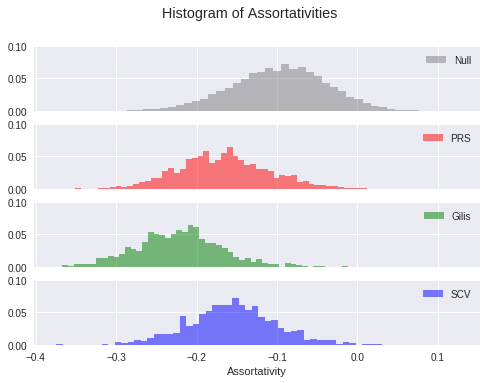

In [43]:
# plot histograms
fig, axarr = plt.subplots(4, sharex=True)
null_weights = np.ones_like(null_assortativities)/float(len(null_assortativities))
evo_weights = np.ones_like(PRS_assortativities)/float(len(PRS_assortativities))
axarr[0].hist(null_assortativities, 50, weights=null_weights, color='grey', alpha=0.5, label='Null')
axarr[1].hist(PRS_assortativities, 50, weights=evo_weights, color='red', alpha=0.5, label='PRS')
axarr[2].hist(Gilis_assortativities, 50, weights=evo_weights, color='green', alpha=0.5, label='Gilis')
axarr[3].hist(SCV_assortativities, 50, weights=evo_weights, color='blue', alpha=0.5, label='SCV')
fig.suptitle('Histogram of Assortativities')
for i in range(4):
    h, l = axarr[i].get_legend_handles_labels()
    axarr[i].legend(h, l)
    axarr[i].set_ylim(0, 0.1)
plt.xlabel('Assortativity')
plt.savefig('../figs/assort_stats.png', bbox_inches='tight')
plt.show()


###################
## do statistics ##
###################

# test if distributions are identical to null
D_assort_PRS, p_assort_PRS = stats.ks_2samp(PRS_assortativities, null_assortativities)
D_assort_Gilis, p_assort_Gilis = stats.ks_2samp(Gilis_assortativities, null_assortativities)
D_assort_SCV, p_assort_SCV = stats.ks_2samp(SCV_assortativities, null_assortativities)
# test if means are different
Z_assort_PRS, U_assort_PRS = stats.ranksums(PRS_assortativities, null_assortativities)
Z_assort_Gilis, U_assort_Gilis = stats.ranksums(Gilis_assortativities, null_assortativities)
Z_assort_SCV, U_assort_SCV = stats.ranksums(SCV_assortativities, null_assortativities)
# package into pandas dataframe for representation
index = ['KS Statistic', 'KS p-Val','Wilcoxon Z Statistic', 'Wilcoxon U-Val']
dict = {
    'PRS' : [D_assort_PRS, p_assort_PRS, Z_assort_PRS, U_assort_PRS],
    'Gilis' : [D_assort_Gilis, p_assort_Gilis, Z_assort_Gilis, U_assort_Gilis],
    'SCV' : [D_assort_SCV, p_assort_SCV, Z_assort_SCV, U_assort_SCV]
}
assort_stats = pd.DataFrame(dict, index=index)
assort_stats.to_html('res/assort_stats.html')